# pNEUMA micro hybrid

Data from: https://open-traffic.epfl.ch/

In [1]:
# Enable interactive plot
%matplotlib notebook
from tqdm.notebook import trange, tqdm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter, FFMpegWriter
from matplotlib.collections import EllipseCollection
from IPython.display import HTML

In [4]:
from numpy.linalg import norm

In [5]:
# https://stackoverflow.com/questions/61341712/
def point_on_line(a, b, p):
    ap = p - a
    ab = b - a
    t = np.dot(ap, ab) / np.dot(ab, ab)
    # if you need the the closest point belonging to the segment
    t = max(0, min(1, t))
    result = a + t * ab
    return result

In [6]:
def takeClosest(num,collection):
    return min(collection,key=lambda x:abs(x-num))
def get_cell_coords(pt, width, height, nx, ny):
    """Get the coordinates of the cell that pt = (x,y) falls in."""

    return int(pt[0] // (width / nx)), int(pt[1] // (height / ny))


def get_neighbours(coords):
    """Return the indexes of points in cells neighbouring cell at coords.

    For the cell at coords = (x,y), return the indexes of points in the cells
    with neighbouring coordinates illustrated below: ie those cells that could 
    contain points closer than r.

                                     ooo
                                    ooooo
                                    ooXoo
                                    ooooo
                                     ooo

    """

    dxdy = [(-1, -2), (0, -2), (1, -2), (-2, -1), (-1, -1), (0, -1), (1, -1),
            (2, -1), (-2, 0), (-1, 0), (1, 0), (2, 0), (-2, 1), (-1, 1),
            (0, 1), (1, 1), (2, 1), (-1, 2), (0, 2), (1, 2), (0, 0)]
    neighbours = []
    for dx, dy in dxdy:
        neighbour_coords = coords[0] + dx, coords[1] + dy
        if not (0 <= neighbour_coords[0] < nx
                and 0 <= neighbour_coords[1] < ny):
            # We're off the grid: no neighbours here.
            continue
        neighbour_cells = cells[neighbour_coords]
        for neighbour_cell in neighbour_cells:
            if neighbour_cell is not None:
                # This cell is occupied: store this index of the contained point.
                neighbours.append(neighbour_cell)
    return neighbours


def point_valid(pt, width, height, nx, ny, r_new):
    """Is pt a valid point to emit as a sample?

    It must be no closer than r from any other point: check the cells in its
    immediate neighbourhood.

    """

    cell_coords = get_cell_coords(pt, width, height, nx, ny)
    for idx in get_neighbours(cell_coords):
        nearby_pt = samples[idx]
        nearby_r = radii[idx]
        r = np.max([r_new, nearby_r])
        #r=r_max
        # Squared distance between or candidate point, pt, and this nearby_pt.
        distance2 = (nearby_pt[0] - pt[0])**2 + (nearby_pt[1] - pt[1])**2
        if distance2 < r**2:
            # The points are too close, so pt is not a candidate.
            return False
    # All points tested: if we're here, pt is valid
    return True


def get_point(k, refpt, refr, constrained=True):
    """Try to find a candidate point relative to refpt to emit in the sample.

    We draw up to k points from the annulus of inner radius r, outer radius 2r
    around the reference point, refpt. If none of them are suitable (because
    they're too close to existing points in the sample), return False.
    Otherwise, return the pt.

    """
    i = 0
    r_new = np.random.choice([r_min, r_max], p=[p_moto, 1 - p_moto])
    # Check when having discrete set of radii!
    if refr == r_min and r_new == r_max:
        r = r_max
    else:
        r = refr
    while i < k:
        i += 1
        rho = np.sqrt(np.random.uniform(r**2, 4 * r**2))
        theta = np.random.uniform(0, 2 * np.pi)
        if constrained and r_new == r_max:
            if (theta > 7 * np.pi / 4) or (theta < np.pi / 4):
                theta = 0
            elif (theta > 3 * np.pi / 4) and (theta < 5 * np.pi / 4):
                theta = np.pi
            y = takeClosest(refpt[1], [2, 6, 10])
            pt = refpt[0] + rho * np.cos(theta), y
        else:
            pt = refpt[0] + rho * np.cos(theta), refpt[1] + rho * np.sin(theta)

        margin = r_min / 2
        if not (margin <= pt[0] < width - margin
                and margin <= pt[1] < height - margin):
            # This point falls outside the domain, so try again.
            continue
        if point_valid(pt, width, height, nx, ny, r_new):
            return pt, r_new

    # We failed to find a suitable point in the vicinity of refpt.
    return False, r_new

In [7]:
# Choose up to k points around each reference point as candidates for a new
# sample point
k = 300
# Minimum distance between samples
r_min = 3
r_max = 6
p_moto = .2
width, height = 100, 12
diff = 3

In [8]:
list_seeds = []
list_samples = []
list_radii = []
list_diameter = []
seed = 0
while len(list_seeds) < 1:
    np.random.seed(seed)

    # Cell side length
    a = r_max / np.sqrt(2)
    # Number of cells in the x- and y-directions of the grid
    nx, ny = int(width / a) + 1, int(height / a) + 1

    # A list of coordinates in the grid of cells
    coords_list = [(ix, iy) for ix in range(nx) for iy in range(ny)]
    # Initilalize the dictionary of cells: each key is a cell's coordinates, the
    # corresponding value is the index of that cell's point's coordinates in the
    # samples list (or None if the cell is empty).
    cells = {coords: [] for coords in coords_list}
    r_new = np.random.choice([r_min, r_max], p=[p_moto, 1 - p_moto])
    radii = [r_new]
    # Pick a random point to start with.
    if r_new == r_max:
        y = np.random.choice([2, 6, 10])
    else:
        y = np.random.uniform(0, height)
    pt = (np.random.uniform(0, width), y)
    samples = [pt]
    # Our first sample is indexed at 0 in the samples list...
    cells[get_cell_coords(pt, width, height, nx, ny)].append(0)
    # ... and it is active, in the sense that we're going to look for more points
    # in its neighbourhood.
    active = [0]
    nsamples = 1
    # As long as there are points in the active list, keep trying to find samples.
    while active:
        # choose a random "reference" point from the active list.
        idx = np.random.choice(active)
        refpt = samples[idx]
        refr = radii[idx]
        # Try to pick a new point relative to the reference point.
        pt, r_new = get_point(k, refpt, refr)
        if pt:
            # Point pt is valid: add it to the samples list and mark it as active
            samples.append(pt)
            radii.append(r_new)
            nsamples += 1
            active.append(len(samples) - 1)
            #cells[get_cell_coords(pt, width, height, nx, ny)] = len(samples) - 1
            cells[get_cell_coords(pt, width, height, nx,
                                  ny)].append(len(samples) - 1)
        else:
            # We had to give up looking for valid points near refpt, so remove it
            # from the list of "active" points.
            active.remove(idx)
    samples = np.array(samples)
    lane_1 = sum(samples[:, 1] == 2)
    lane_2 = sum(samples[:, 1] == 6)
    lane_3 = sum(samples[:, 1] == 10)
    radii = np.array(radii)
    diameter = np.where(radii == r_max, 2, radii)
    diameter = np.where(radii == r_min, 1, diameter)
    is_car = diameter == 2
    effective_car_ratio = sum(is_car) / len(is_car)
    con_1 = (np.abs(lane_1 - lane_2) < diff)
    con_2 = (np.abs(lane_2 - lane_3) < diff)
    con_3 = (effective_car_ratio > .75)
    con_4 = (len(samples) > 25)
    if con_1 and con_2 and con_3 and con_4:
        print(len(samples))
        print(lane_1, lane_2, lane_3)
        print(effective_car_ratio)
        list_seeds.append(seed)
        list_samples.append(samples)
        list_radii.append(radii)
        list_diameter.append(diameter)
    seed += 1

29
8 8 6
0.7586206896551724


In [9]:
list_seeds

[99]

In [10]:
sel = 0
seed = list_seeds[sel]
np.random.seed(seed)
samples = list_samples[sel]
radii = list_radii[sel]
diameter = list_diameter[sel]
is_car = diameter == 2
is_car

array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
       False,  True, False,  True,  True,  True,  True, False,  True,
        True,  True])

<IPython.core.display.Javascript object>


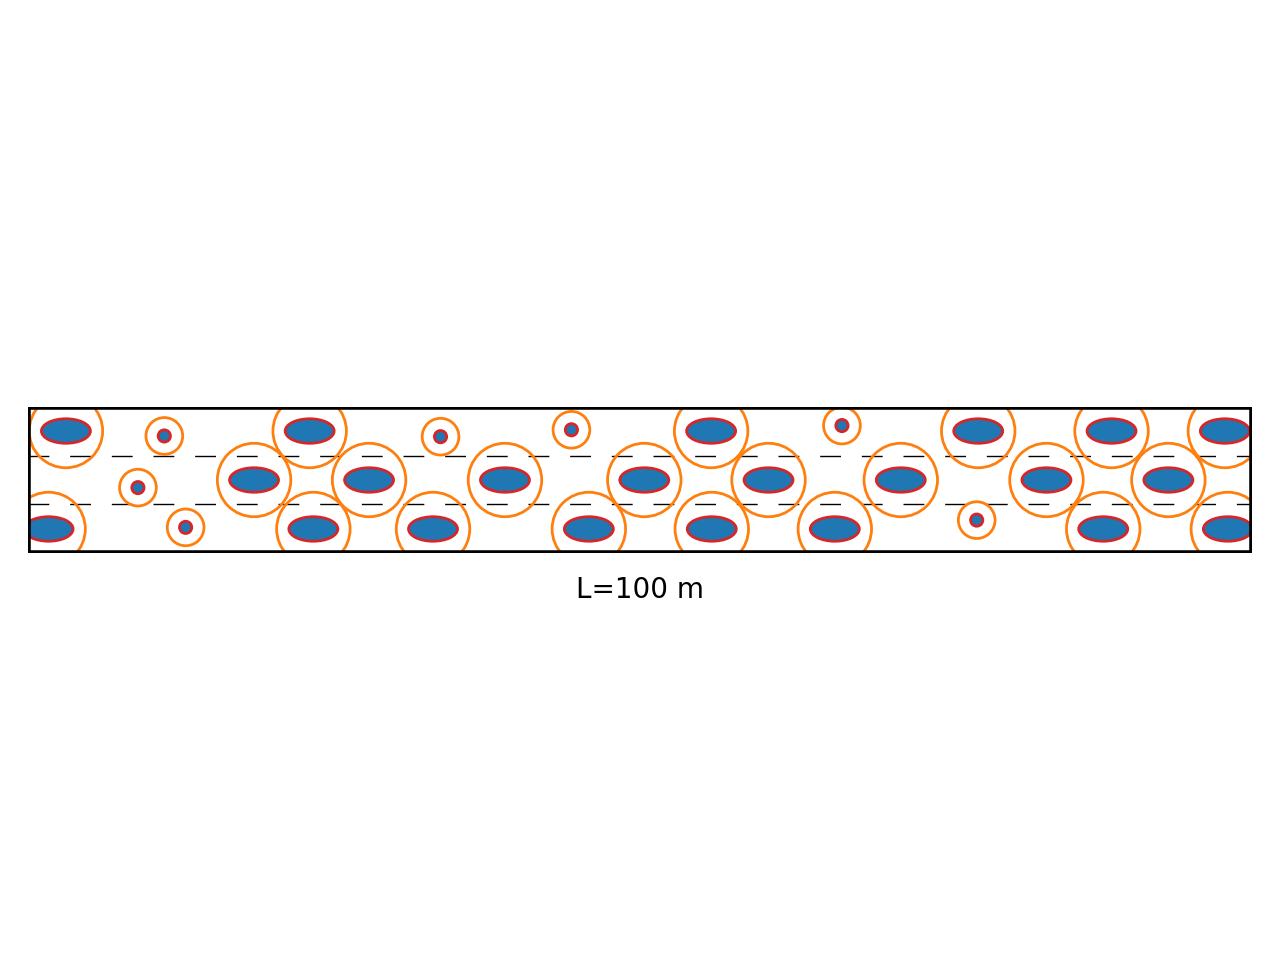

In [11]:
fig = plt.figure()
ax = fig.add_subplot(
    111,
    aspect='equal',
    #autoscale_on=False,
    xlim=(0, width),
    ylim=(0, height))
ax.set_xticks(np.linspace(0, width, nx + 1))
ax.set_yticks(np.linspace(0, height, ny + 1))
# rect is the box edge
rect = plt.Rectangle([0, 0], width, height, ec='k', lw=2, fc='none')
ax.add_patch(rect)
ax.add_collection(
    EllipseCollection(widths=radii,
                      heights=radii,
                      angles=0,
                      units='xy',
                      offsets=samples,
                      fc='none',
                      ec='tab:orange',
                      zorder=-1,
                      transOffset=ax.transData))
radii = np.array(radii)
diameter = np.where(radii == r_max, 2, radii)
diameter = np.where(radii == r_min, 1, diameter)
diameter
ax.add_collection(
    EllipseCollection(widths=2 * diameter[is_car],
                      heights=diameter[is_car],
                      angles=0,
                      units='xy',
                      offsets=samples[is_car],
                      fc='tab:blue',
                      ec='tab:red',
                      zorder=-1,
                      transOffset=ax.transData))
ax.add_collection(
    EllipseCollection(widths=diameter[~is_car],
                      heights=diameter[~is_car],
                      angles=0,
                      units='xy',
                      offsets=samples[~is_car],
                      fc='tab:blue',
                      ec='tab:red',
                      zorder=-1,
                      transOffset=ax.transData))
plt.xlim(0, width)
plt.ylim(0, height)
ax.grid(zorder=-10, ls='--')
if height > 20 or width > 40:
    plt.axis('off')
else:
    plt.scatter(*zip(*samples), color='tab:blue', lw=0, marker='.')
bbox = dict(fc="white", ec="none")
ax.text(width / 2, -3, "L=100 m", ha="center", va="center", bbox=bbox)
plt.hlines([4, 8],
           xmin=0,
           xmax=width,
           color='k',
           ls= (0, (15, 15)),
           lw=.5,
           zorder=-100)
plt.tight_layout(pad=1)
fig.savefig('./data/pNEUMA/model/blue.jpg', dpi=300)
plt.show()

In [12]:
eps = np.finfo(float).eps

In [212]:
"""
Animation of Elastic collisions with Gravity

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""


class ParticleBox:
    """Orbits class
    
    init_state is an [N x 4] array, where N is the number of particles:
       [[x1, y1, vx1, vy1],
        [x2, y2, vx2, vy2],
        ...               ]

    bounds is the size of the box: [xmin, xmax, ymin, ymax]
    """
    def __init__(self,
                 init_state=[[1, 0, 0, -1], [-0.5, 0.5, 0.5, 0.5],
                             [-0.5, -0.5, -0.5, 0.5]],
                 bounds=[0, width, 0, height]):
        self.init_state = np.asarray(init_state, dtype=float)
        self.state = self.init_state.copy()
        self.time_elapsed = 0
        self.bounds = bounds

    def step(self, dt, flag=True):
        """step once by dt seconds"""
        self.time_elapsed += dt
        initial = copy.deepcopy(self.state)
        # update positions
        self.state[:, :2] += dt * self.state[:, 2:]
        # prediction of a future situation
        x_a = self.state[:, :2] + t_a * self.state[:, 2:]
        for i in range(len(self.state[:])):
            if is_car[i]:
                #r_i = r_cars
                a_i = a_cars
                b_i = b_cars
            else:
                #r_i = r_moto
                a_i = a_moto
                b_i = b_moto
            goal = [self.bounds[1], initial[i, 1]]
            # set of interacting agents
            N = []
            # strength of interaction
            R = []
            # position vector i
            x_i = self.state[i, :2]
            # relative position to goal
            e_i_0 = (goal - x_i) / np.linalg.norm((goal - x_i))
            e_i_d = np.copy(e_i_0)
            # normal vector to goal direction
            e_i_0_n = np.cross(e_i_0, [0, 0, 1])[:2]
            # velocity vector i
            v_i = self.state[i, 2:]
            # normalized vector i
            e_i = v_i / np.linalg.norm(v_i)
            # deviation in radians
            phi_i = np.arctan2(e_i[1], e_i[0])
            phi_i_0 = np.arctan2(e_i_0[1], e_i_0[0])
            # normal vector to current direction
            e_i_n = np.cross(e_i, [0, 0, 1])[:2]
            for j in range(len(self.state)):
                if j != i:
                    if is_car[j]:
                        #r_j = r_cars
                        a_j = a_cars
                        b_j = b_cars
                    else:
                        #r_j = r_moto
                        a_j = a_moto
                        b_j = b_moto
                    # position vector j
                    x_j = self.state[j, :2]
                    # distance from i to j
                    s_i_j = np.linalg.norm(x_j - x_i)
                    # relative position to i
                    e_i_j = (x_j - x_i) / np.linalg.norm((x_j - x_i))
                    phi_i_j = np.arctan2(e_i_j[1], e_i_j[0])
                    # velocity vector j
                    v_j = self.state[j, 2:]
                    # normalized vector i
                    e_j = v_j / np.linalg.norm(v_j)
                    # deviation in radians
                    phi_j = np.arctan2(e_j[1], e_j[0])
                    # perception of actual situation
                    con_1 = np.dot(e_i, e_i_j) > 0
                    con_2 = np.dot(e_i_0, e_i_j) > 0
                    #d_i_j = r_i + r_j
                    d_i_j = a_i + norm(
                        np.array([
                            a_j * np.cos(phi_i - phi_j),
                            b_j * np.sin(phi_i - phi_j)
                        ]))
                    con_3 = np.abs(np.dot(e_i, e_i_j)) <= d_i_j / s_i_j
                    #d_i_j = r_i + r_j
                    d_i_j = norm(
                        np.array([
                            a_i * np.cos(phi_i - phi_i_0),
                            b_i * np.sin(phi_i - phi_i_0)
                        ])) + norm(
                            np.array([
                                a_j * np.cos(phi_j - phi_i_0),
                                b_j * np.sin(phi_j - phi_i_0)
                            ]))
                    con_4 = np.abs(np.dot(e_i_0, e_i_j)) <= d_i_j / s_i_j
                    if con_1 or con_2 or con_3 or con_4:
                        N.append(j)
                        if a_i == a_moto:
                            a_i_j = k * (1 + (1 - np.dot(e_i_0, e_j)) / 2)
                            #d_i_j = r_i + r_j
                            d_i_j = norm(
                                np.array([
                                    a_i * np.cos(phi_i - phi_i_j),
                                    b_i * np.sin(phi_i - phi_i_j)
                                ])) + norm(
                                    np.array([
                                        a_j * np.cos(phi_j - phi_i_j),
                                        b_j * np.sin(phi_j - phi_i_j)
                                    ]))
                            s_a = np.max(
                                [d_i_j, np.dot(x_a[j] - x_a[i], e_i_j)])
                            R_i_j = a_i_j * np.exp((d_i_j - s_a) / D)
                            R.append(R_i_j)
                            # predicted relative position to i
                            e_a_i_j = x_a[j] - x_i
                            # direction of influence from j
                            n_i_j = -np.sign(np.dot(e_a_i_j,
                                                    e_i_0_n)) * e_i_0_n
                            # optimal direction
                            e_i_d += (R_i_j * n_i_j)
            # influence of walls
            if a_i == a_moto:
                s_w_i = 1e+6
                for w in range(2):
                    A_w = np.array([box.bounds[0], box.bounds[2 + w]])
                    B_w = np.array([box.bounds[1], box.bounds[2 + w]])
                    C_w = point_on_line(A_w, B_w, x_i)
                    s_i_w = np.linalg.norm(x_i - C_w)
                    e_i_w = (x_i - C_w) / s_i_w
                    a_w = np.arccos(np.dot(e_i, -e_i_w))
                    #d_i_w = r_i
                    d_i_w = norm(
                        np.array([
                            a_i * np.cos(phi_i - a_w),
                            b_i * np.sin(phi_i - a_w)
                        ]))
                    R_i_w = k_w * np.exp((d_i_w - s_i_w) / D_w)
                    e_i_d += R_i_w * e_i_w
                    if (np.dot(e_i, e_i_w) < 0):
                        s_w_i = np.abs((s_i_w - d_i_w) / np.cos(a_w))
                e_i_d /= np.linalg.norm(e_i_d)
            # update direction
            v_0 = v_desired[i]
            if ~is_car[i]:
                e_i += dt * (e_i_d - e_i) / tau
            e_i /= np.linalg.norm(e_i)
            # normal vector to new direction
            e_i_n = np.cross(e_i, [0, 0, 1])[:2]
            # set of imminently colliding agents
            J = []
            s = []
            for j in N:
                if is_car[j]:
                    #r_j = r_cars
                    a_j = a_cars
                    b_j = b_cars
                else:
                    #r_j = r_moto
                    a_j = a_moto
                    b_j = b_moto
                x_j = self.state[j, :2]
                s_i_j = np.linalg.norm(x_j - x_i)
                # relative position to i
                e_i_j = (x_j - x_i) / np.linalg.norm((x_j - x_i))
                #d_i_j = (r_i + r_j)
                d_i_j = b_i + (b_j * np.sin(phi_i - phi_j))
                if (np.dot(e_i, e_i_j) > 0) and (np.abs(np.dot(e_i_n, e_i_j))
                                                 <= d_i_j / s_i_j):
                    J.append(j)
                    s.append(s_i_j)
            # speed of agend i
            if len(J) > 0:
                j = np.argmin(s)
                if is_car[J[j]]:
                    #r_j = r_cars
                    a_j = a_cars
                    b_j = b_cars
                else:
                    #r_j = r_moto
                    a_j = a_moto
                    b_j = b_moto
                # maximum collision-free distance
                #d_i_j = (r_i + r_j)
                d_i_j = a_i + norm(
                    np.array([
                        a_j * np.cos(phi_i - phi_j),
                        b_j * np.sin(phi_i - phi_j)
                    ]))
                s_i = min(s) - d_i_j
                if s_i < 0:
                    raise Exception(
                        f"Sorry, negative distance! i:{i}, j:{J[j]}")
                if a_i == a_moto:
                    v_i = min(v_0, max(eps, s_i / T), max(eps, s_w_i / T))
                else:
                    v_i = min(v_0, max(eps, s_i / T))
            else:
                v_i = np.linalg.norm(self.state[i, 2:])
                v_i = v_0
                if a_i == a_moto:
                    v_i = min(v_i, max(eps, s_w_i / T))
            v_i *= e_i
            # assign new velocities
            self.state[i, 2:] = v_i
        # check for crossing boundary
        crossed_x2 = (self.state[:, 0] > self.bounds[1] + r_cars) & is_car
        self.state[crossed_x2, 0] = self.bounds[0] - r_cars
        crossed_x2 = (self.state[:, 0] > self.bounds[1] + r_moto) & ~is_car
        self.state[crossed_x2, 0] = self.bounds[0] - r_moto

In [213]:
v_cars = 8.85
v_moto = 10
a_cars = 2
b_cars = 1
a_moto = .5
b_moto = .5
r_cars = a_cars
r_moto = a_moto

In [214]:
dt = .05
tau = .3
k = .1
D = 3
T = .9
t_a = .88

In [215]:
k_w = 2 * k
D_w = D
k_v = 2 * k
D_v = D
max_length = 20

In [216]:
#------------------------------------------------------------
# set up initial state
np.random.seed(seed)
population = len(samples)
init_state = np.zeros((population, 2))
init_state[:,1] = 0
init_state[is_car,0] = v_cars
init_state[~is_car,0] = v_moto
init_state = np.hstack((samples, init_state))
box = ParticleBox(init_state)
v_desired = copy.deepcopy(init_state[:, 2])

In [217]:
moto_x = []
moto_y = []
for i in trange(6000):
    try:
        box.step(dt)
        moto_x.extend(box.state[~is_car][:,0])
        moto_y.extend(box.state[~is_car][:,1])
    except:
        print(i)
        break

  0%|          | 0/6000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


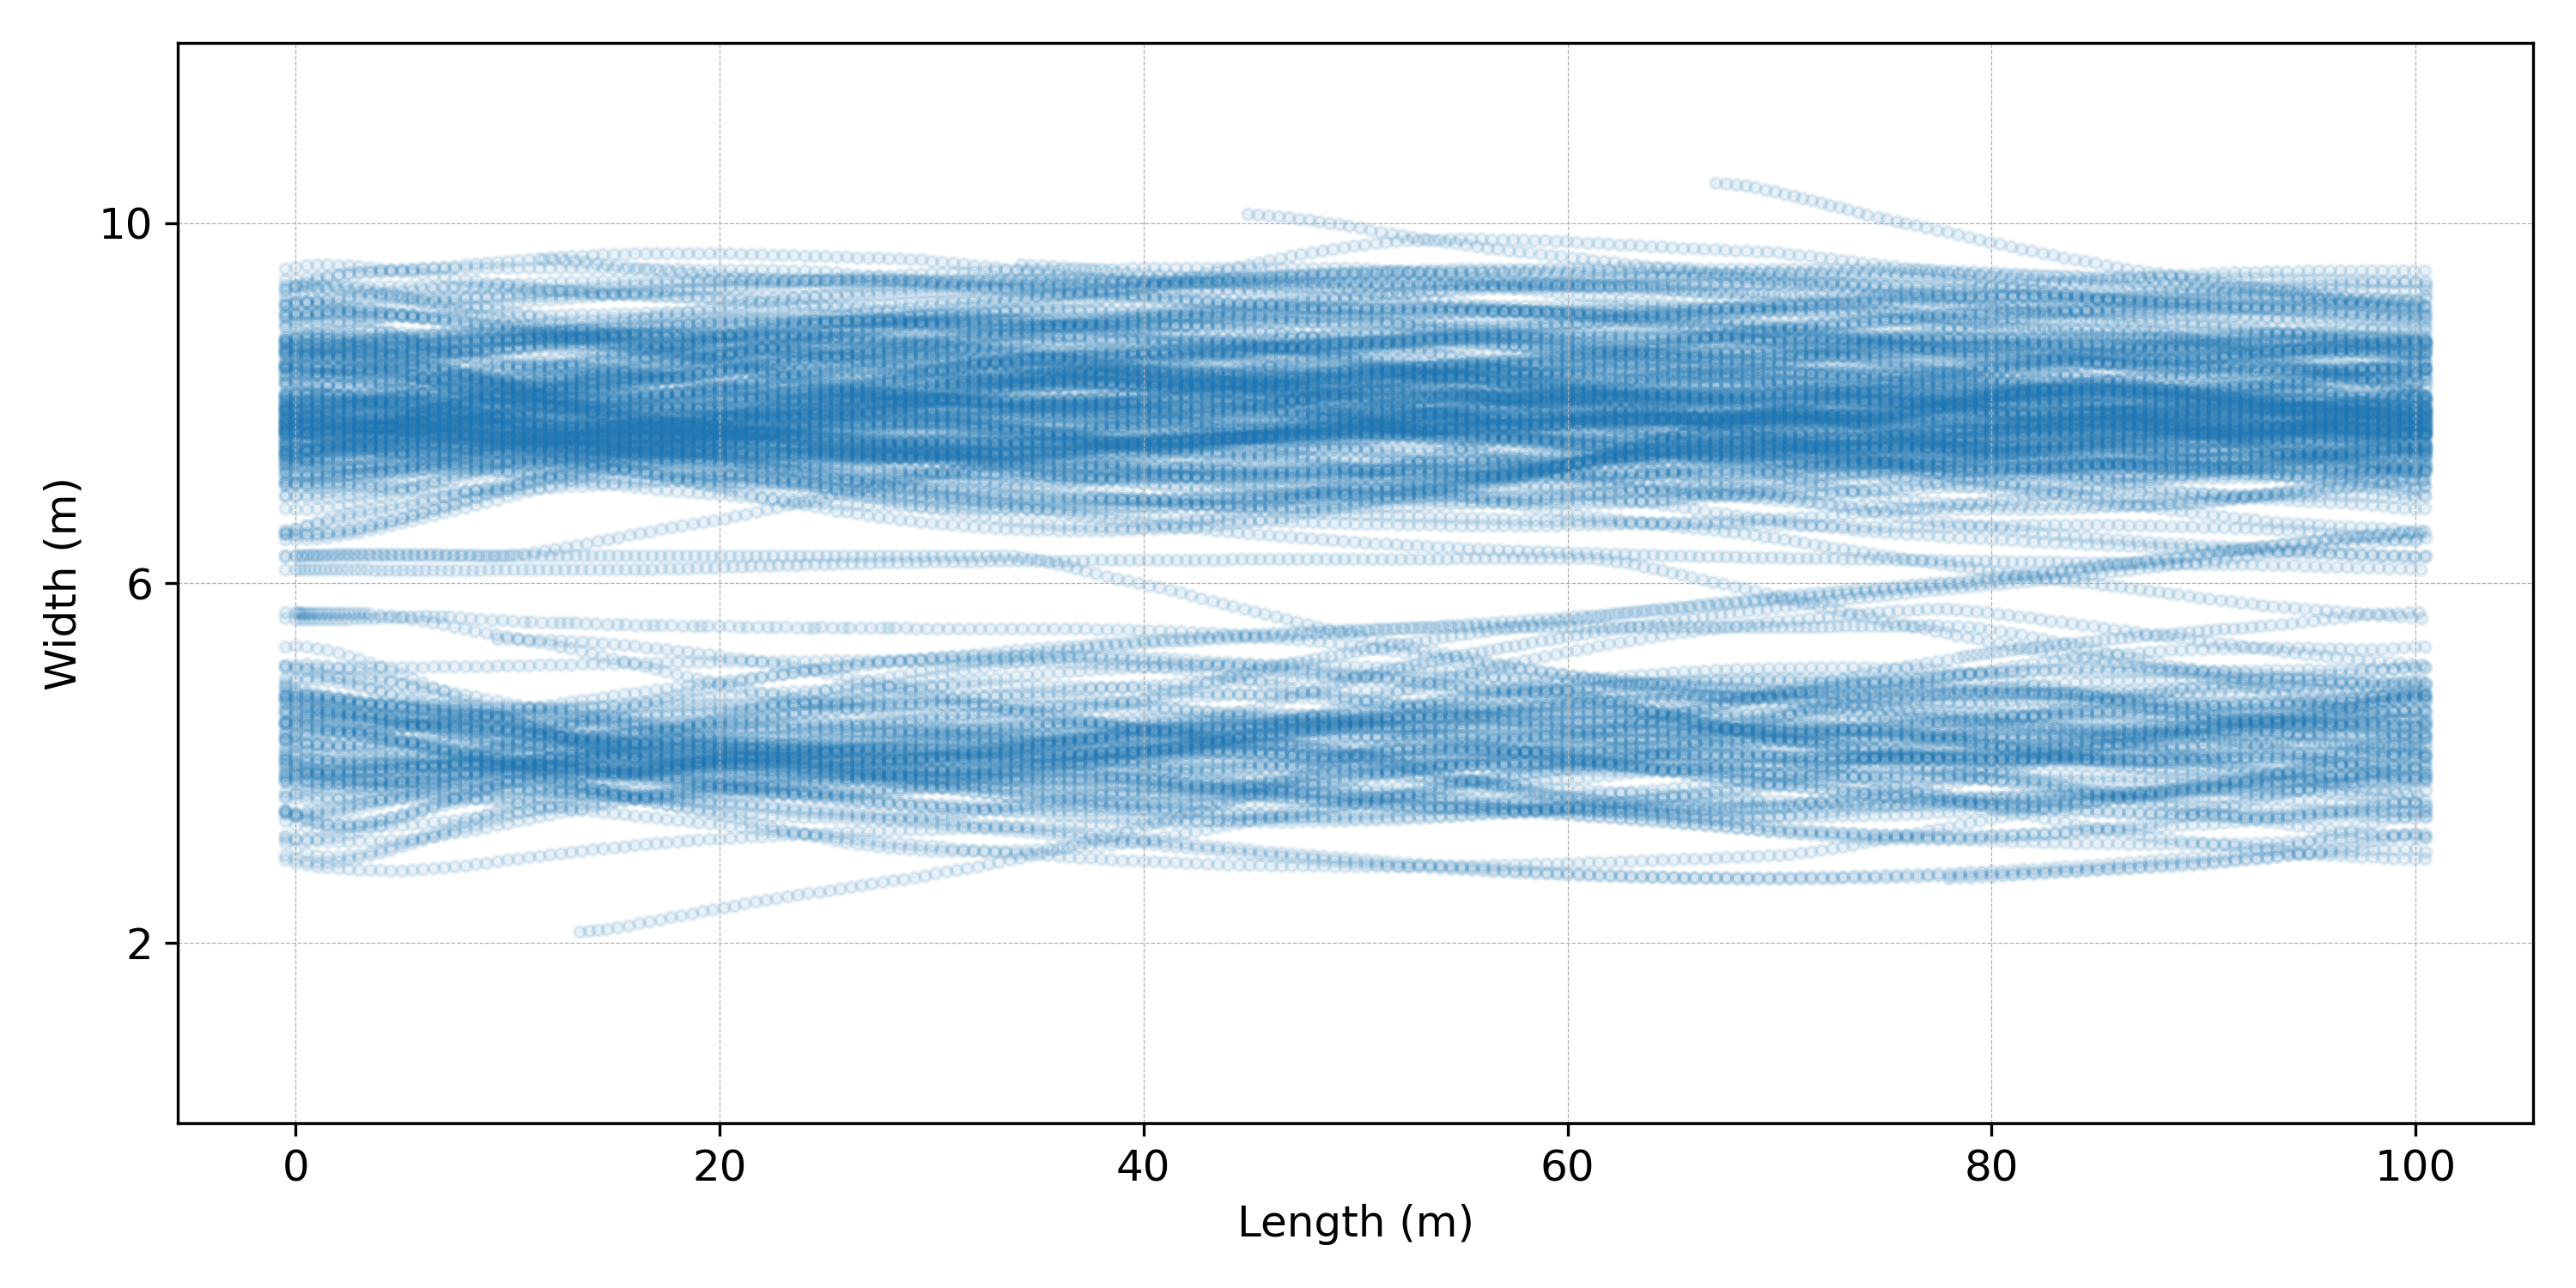

In [224]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=150)
font = {'size': 12}
plt.rc('font', **font)
ax.set_ylim((0, 12))
ax.set_yticks(np.linspace(2, 10, 3))
ax.grid(zorder=1, ls='--', lw=.3)
plt.scatter(moto_x, moto_y, s=10, alpha=.1)
ax.set_xlabel('Length (m)')
ax.set_ylabel('Width (m)')
plt.tight_layout(pad=1)
fig.savefig('./data/pNEUMA/model/virtual.jpg', dpi=300)
#plt.hlines([2,6,10], xmin=0,xmax=100, color='k', ls='--')
plt.show()

<IPython.core.display.Javascript object>


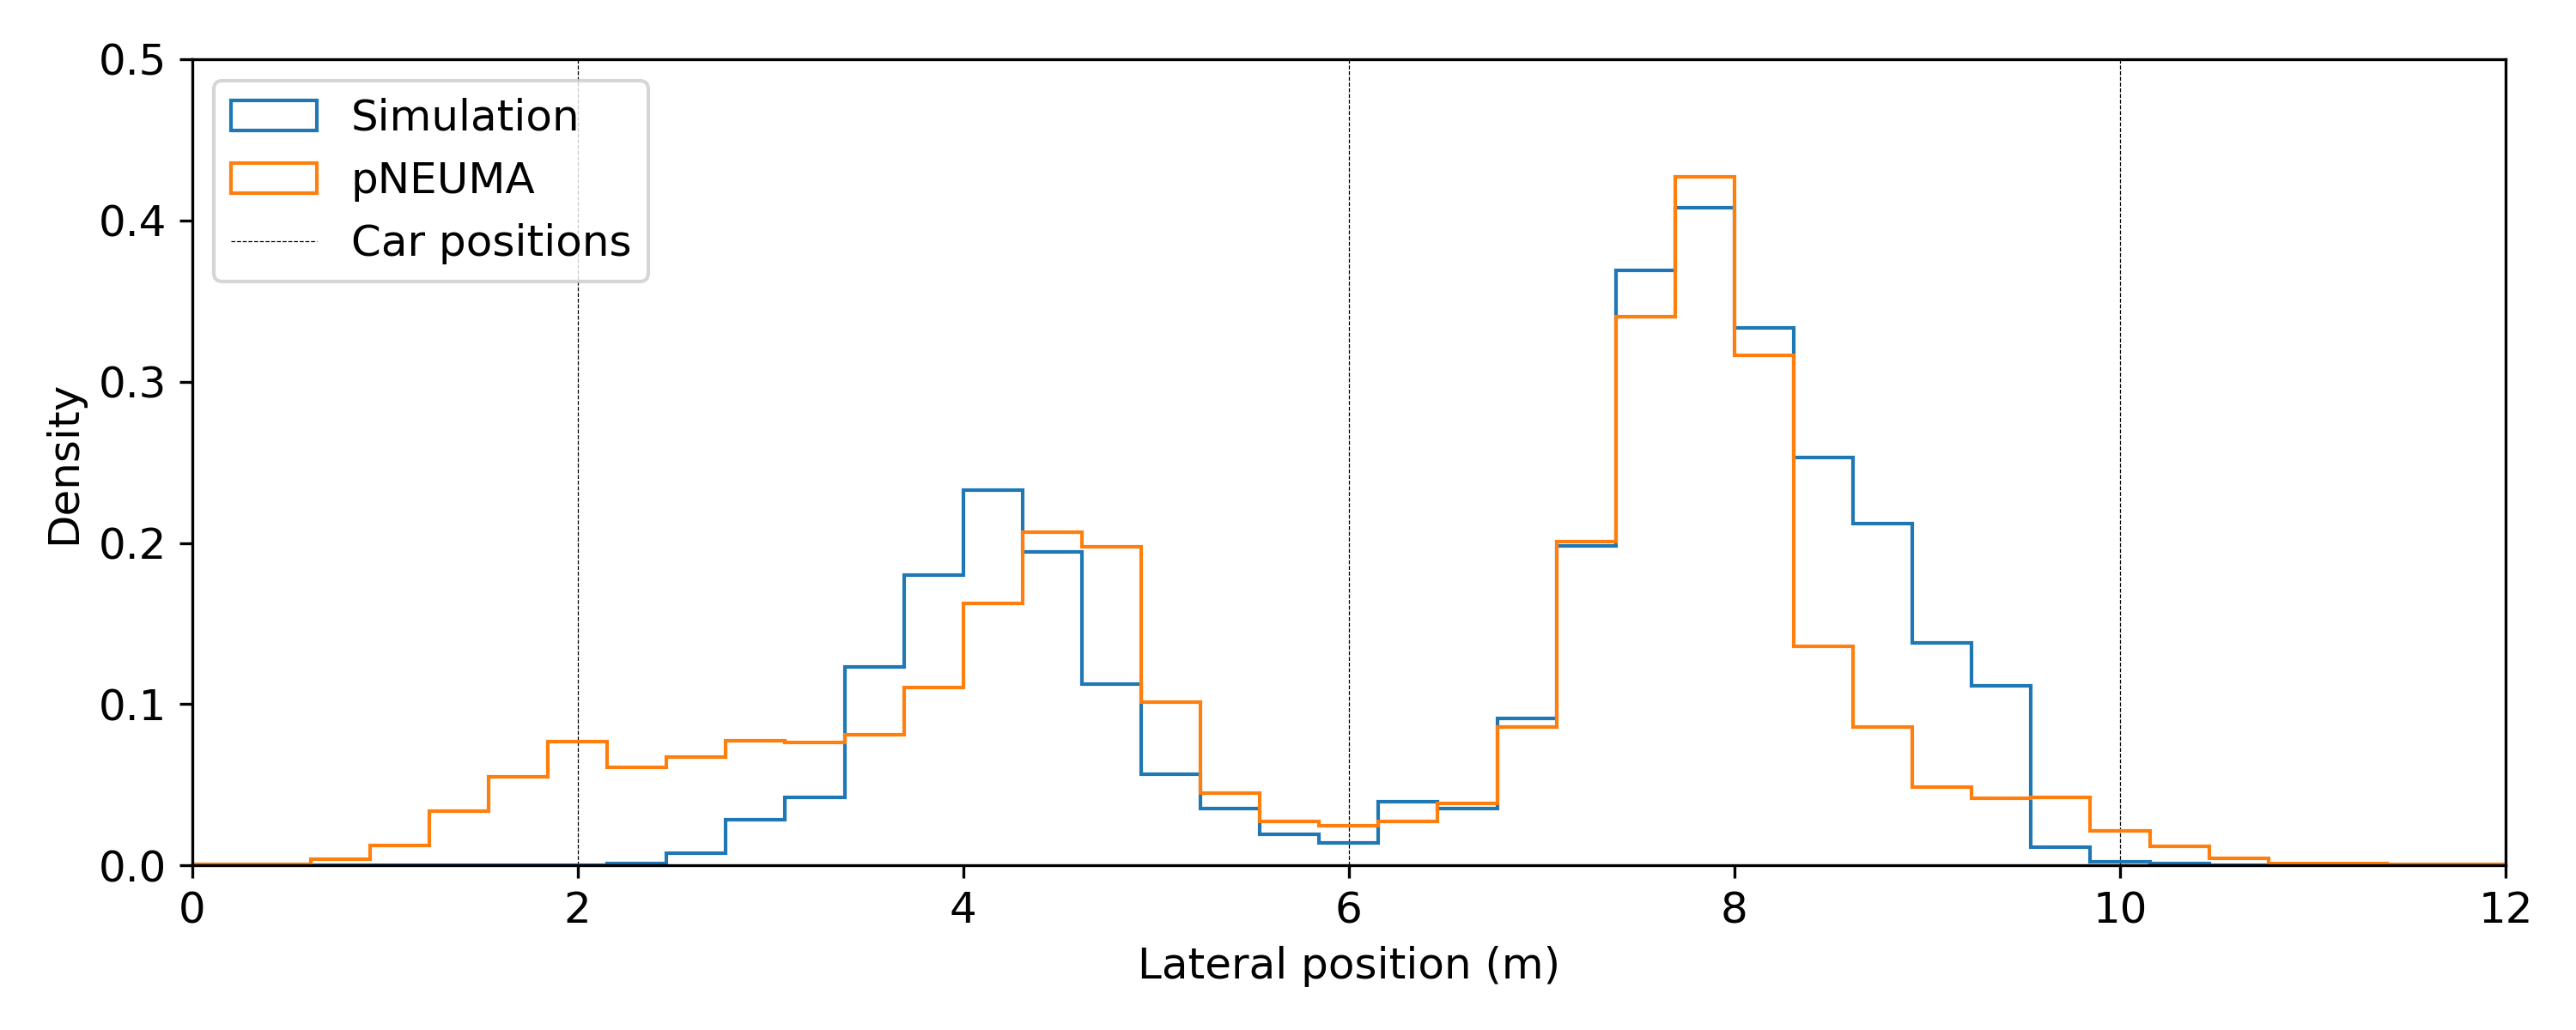

In [229]:
import pandas as pd

real_data = pd.read_csv(f"real_data.zip")

pd.options.mode.chained_assignment = None 

fig, ax = plt.subplots(figsize=(10, 4), dpi=150)
font = {'size': 12}
plt.rc('font', **font)
ax.set_xlim((0, 12))
ax.set_ylim((0, .5))
bins = np.linspace(0, 12, 40)
plt.hist(moto_y, bins=bins, histtype='step', density=True, label='Simulation')
plt.hist(real_data[(real_data.type == 'Motorcycle') & (real_data.y >= -4) &
                   (~real_data.stay)].y,
         bins=bins,
         histtype='step',
         density=True,
         label='pNEUMA')
plt.vlines([2, 6, 10],
           ymin=0,
           ymax=.5,
           color='k',
           ls='--',
           lw=.3,
           label='Car positions')
plt.legend(loc='upper left')
ax.set_ylabel('Density')
ax.set_xlabel('Lateral position (m)')
fig.tight_layout(pad=1)
fig.savefig('./data/pNEUMA/model/step.jpg', dpi=300)
#plt.hist(sample[(sample.type != 'Motorcycle') & (sample.y > -5)].y, bins=60,density=True)

plt.show()

In [93]:
#np.round(box.state)

In [94]:
ego = 20

In [194]:
fig = plt.figure()
ax = fig.add_subplot(111,
                     aspect='equal',
                     autoscale_on=False,
                     xlim=(box.bounds[0], box.bounds[1]),
                     ylim=(box.bounds[2], box.bounds[3]))
fig.tight_layout()
ax.set_yticks(np.linspace(2, 10, 3))
ax.grid(zorder=-10, ls='--')
# prediction of a future situation
x_a = box.state[:, :2] + t_a * box.state[:, 2:]

mode = 'ego'
perceive = True
anticipate = True
act = True
scale = 4
initial = copy.deepcopy(box.state)

for i in range(len(box.state)):
    if mode == 'all':
        cond = True
    else:
        cond = (i == ego)
    if cond:
        if is_car[i]:
            r_i = r_cars
            a_i = a_cars
            b_i = b_cars
        else:
            r_i = r_moto
            a_i = a_moto
            b_i = b_moto
        goal = [box.bounds[1] + 50, initial[i, 1]]
        # set of interacting agents
        N = []
        # strength of interaction
        R = []
        # position vector i
        x_i = box.state[i, :2]
        # relative position to goal
        e_i_0 = (goal - x_i) / np.linalg.norm((goal - x_i))
        e_i_d = np.copy(e_i_0)
        # normal vector to goal direction
        e_i_0_n = np.cross(e_i_0, [0, 0, 1])[:2]
        # velocity vector i
        v_i = box.state[i, 2:]
        # normalized vector i
        e_i = v_i / np.linalg.norm(v_i)
        # deviation in radians
        phi_i = np.arctan2(e_i[1], e_i[0])
        phi_i_0 = np.arctan2(e_i_0[1], e_i_0[0])
        print(np.degrees(phi_i), phi_i)
        # normal vector to current direction
        e_i_n = np.cross(e_i, [0, 0, 1])[:2]
        for j in range(len(box.state)):
            if j != i:
                if is_car[j]:
                    r_j = r_cars
                    a_j = a_cars
                    b_j = b_cars
                else:
                    r_j = r_moto
                    a_j = a_moto
                    b_j = b_moto
                # position vector j
                x_j = box.state[j, :2]
                s_i_j = np.linalg.norm(x_j - x_i)
                # relative position to i
                e_i_j = (x_j - x_i) / norm((x_j - x_i))
                phi_i_j = np.arctan2(e_i_j[1], e_i_j[0])
                # velocity vector j
                v_j = box.state[j, 2:]
                # normalized vector i
                e_j = v_j / norm(v_j)
                # deviation in radians
                phi_j = np.arctan2(e_j[1], e_j[0])
                # perception of actual situation
                cond_1 = np.dot(e_i, e_i_j) > 0
                cond_2 = np.dot(e_i_0, e_i_j) > 0
                #d_i_j = r_i + r_j
                d_i_j = a_i + norm(
                    np.array([
                        a_j * np.cos(phi_i - phi_j),
                        b_j * np.sin(phi_i - phi_j)
                    ]))
                cond_3 = np.abs(np.dot(e_i, e_i_j)) <= d_i_j / s_i_j
                #d_i_j = r_i + r_j
                d_i_j = norm(
                    np.array([
                        a_i * np.cos(phi_i - phi_i_0),
                        b_i * np.sin(phi_i - phi_i_0)
                    ])) + norm(
                        np.array([
                            a_j * np.cos(phi_j - phi_i_0),
                            b_j * np.sin(phi_j - phi_i_0)
                        ]))
                cond_4 = np.abs(np.dot(e_i_0, e_i_j)) <= d_i_j / s_i_j
                if cond_1 or cond_2 or cond_3 or cond_4:
                    N.append(j)
                    a_i_j = k * (1 + (1 - np.dot(e_i_0, e_j)) / 2)
                    #d_i_j = r_i + r_j
                    d_i_j = norm(
                        np.array([
                            a_i * np.cos(phi_i - phi_i_j),
                            b_i * np.sin(phi_i - phi_i_j)
                        ])) + norm(
                            np.array([
                                a_j * np.cos(phi_j - phi_i_j),
                                b_j * np.sin(phi_j - phi_i_j)
                            ]))
                    s_a = np.max([d_i_j, np.dot(x_a[j] - x_a[i], e_i_j)])
                    R_i_j = a_i_j * np.exp((d_i_j - s_a) / D)
                    R.append(R_i_j)
                    # predicted relative position to i
                    e_a_i_j = x_a[j] - x_i
                    # direction of influence from j
                    n_i_j = -np.sign(np.dot(e_a_i_j, e_i_0_n)) * e_i_0_n
                    # optimal direction
                    e_i_d += (R_i_j * n_i_j)
        # influence of walls
        s_w_i = 1e+6
        A_w = np.array([box.bounds[0] - 100, box.bounds[3]])
        B_w = np.array([box.bounds[1], box.bounds[3]])
        C_w = point_on_line(A_w, B_w, x_i)
        s_i_w = np.linalg.norm(x_i - C_w)
        e_i_w = (x_i - C_w) / s_i_w
        a_w = np.arccos(np.dot(e_i, -e_i_w))
        #d_i_j = r_i + r_j
        d_i_w = norm(
            np.array([a_i * np.cos(phi_i - a_w), b_i * np.sin(phi_i - a_w)]))
        R_i_w = k_w * np.exp((d_i_w - s_i_w) / D_w)
        e_i_d += R_i_w * e_i_w
        if (np.dot(e_i, e_i_w) < 0):
            print(f'North {np.round(s_i_w,1)}')
            print(f'a_w: {np.degrees(a_w)}')
            s_w_i = np.abs((s_i_w - r_i) / np.cos(a_w))
        A_v = np.array([box.bounds[0] - 100, box.bounds[2]])
        B_v = np.array([box.bounds[1], box.bounds[2]])
        C_v = point_on_line(A_v, B_v, x_i)
        s_i_v = np.linalg.norm(x_i - C_v)
        e_i_v = (x_i - C_v) / s_i_v
        a_v = np.arccos(np.dot(e_i, -e_i_v))
        d_i_v = norm(
            np.array([a_i * np.cos(phi_i - a_v), b_i * np.sin(phi_i - a_v)]))
        R_i_v = k_v * np.exp((d_i_v - s_i_v) / D_v)
        e_i_d += R_i_v * e_i_v
        if (np.dot(e_i, e_i_v) < 0):
            print(f'South {np.round(s_i_v,1)}')
            print(f'a_v: {np.degrees(a_v)}')
            s_w_i = np.abs((s_i_v - r_i) / np.cos(a_v))
        print(f's_w_i: {s_w_i}')
        e_i_d /= np.linalg.norm(e_i_d)
        if perceive:
            ax.quiver(x_i[0],
                      x_i[1],
                      scale * e_i[0],
                      scale * e_i[1],
                      color='k',
                      zorder=100,
                      scale_units='xy',
                      scale=1)
            ax.quiver(x_i[0],
                      x_i[1],
                      scale * e_i_0[0],
                      scale * e_i_0[1],
                      color='tab:green',
                      zorder=100,
                      scale_units='xy',
                      scale=1)
            ax.quiver(x_i[0],
                      x_i[1],
                      scale * e_i_0_n[0],
                      scale * e_i_0_n[1],
                      color='tab:purple',
                      zorder=100,
                      scale_units='xy',
                      scale=1)
        if perceive and anticipate:
            ax.quiver(x_i[0],
                      x_i[1],
                      scale * e_i_d[0],
                      scale * e_i_d[1],
                      color='tab:red',
                      zorder=100,
                      scale_units='xy',
                      scale=1)
        # update direction
        if np.abs(box.state[i, 1]) != 2:
            v_0 = v_moto
            e_i += dt * (e_i_d - e_i) / tau
        else:
            v_0 = v_cars
        e_i /= np.linalg.norm(e_i)
        # normal vector to new direction
        e_i_n = np.cross(e_i, [0, 0, 1])[:2]
        if perceive and anticipate and act:
            ax.quiver(x_i[0],
                      x_i[1],
                      scale * e_i[0],
                      scale * e_i[1],
                      color='tab:grey',
                      zorder=100,
                      scale_units='xy',
                      scale=1)
        # submodel for the speed
        # set of imminently colliding agents
        J = []
        s = []
        for j in N:
            if is_car[j]:
                r_j = r_cars
                a_j = a_cars
                b_j = b_cars
            else:
                r_j = r_moto
                a_j = a_moto
                b_j = b_moto
            x_j = box.state[j, :2]
            s_i_j = np.linalg.norm(x_j - x_i)
            # relative position to i
            e_i_j = (x_j - x_i) / np.linalg.norm((x_j - x_i))
            d_i_j = (r_i + r_j)
            #d_i_j = a_i + norm(
            #    np.array([
            #        a_j * np.cos(phi_i - phi_j), b_j * np.sin(phi_i - phi_j)
            #    ]))
            if (np.dot(e_i, e_i_j) > 0) and (np.abs(np.dot(e_i_n, e_i_j)) <=
                                             d_i_j / s_i_j):
                J.append(j)
                s.append(s_i_j)
        if len(s) > 0:
            j = np.argmin(s)
            if np.abs(box.state[J[j], 1]) in np.array([2, 6, 10]):
                r_j = r_cars
                a_j = a_cars
                b_j = b_cars
            else:
                r_j = r_moto
                a_j = a_moto
                b_j = b_moto
            # maximum collision-free distance
            #d_i_j = (r_i + r_j)
            d_i_j = a_i + norm(
                np.array([
                    a_j * np.cos(phi_i - phi_j), b_j * np.sin(phi_i - phi_j)
                ]))
            s_i = min(s) - d_i_j
            if s_i < 0:
                print(s_i)
            # speed of agend i
            v_i = min(v_0, max(1e-6, s_i / T), max(1e-6, s_w_i / T))
            print(f'v_i: {v_i}')
            v_i *= e_i
        else:
            v_i = np.linalg.norm(box.state[i, 2:])
            v_i = min(v_i, max(1e-6, s_w_i / T))
            print(f'v_i: {v_i}')
            v_i *= e_i

ax.add_collection(
    EllipseCollection(widths=diameter,
                      heights=diameter,
                      angles=0,
                      units='xy',
                      offsets=list(zip(box.state[:, 0], box.state[:, 1])),
                      fc='none',
                      ec='tab:blue',
                      transOffset=ax.transData))
if mode != 'all':
    ax.add_collection(
        EllipseCollection(widths=2 * diameter[ego],
                          heights=1 * diameter[ego],
                          angles=[np.degrees(phi_i)],
                          units='xy',
                          offsets=[(box.state[ego, 0], box.state[ego, 1])],
                          fc='tab:blue',
                          zorder=2,
                          transOffset=ax.transData))
    if perceive:
        ax.add_collection(
            EllipseCollection(widths=diameter[N],
                              heights=diameter[N],
                              angles=0,
                              units='xy',
                              offsets=list(
                                  zip(box.state[N, 0], box.state[N, 1])),
                              fc='none',
                              ec='tab:orange',
                              transOffset=ax.transData))
    if anticipate:
        multiplier = 1
        ax.add_collection(
            EllipseCollection(widths=np.multiply(R, multiplier),
                              heights=np.multiply(R, multiplier),
                              angles=0,
                              units='xy',
                              offsets=list(zip(x_a[N, 0], x_a[N, 1])),
                              fc='none',
                              ec='tab:red',
                              transOffset=ax.transData))
    if act:
        if len(J) > 0:
            ax.add_collection(
                EllipseCollection(widths=diameter[J],
                                  heights=diameter[J],
                                  angles=0,
                                  units='xy',
                                  offsets=list(
                                      zip(box.state[J, 0], box.state[J, 1])),
                                  fc='tab:orange',
                                  ec='tab:orange',
                                  zorder=-1,
                                  transOffset=ax.transData))
plt.show()

<IPython.core.display.Javascript object>

0.5057411592302024 0.008826848391419942
North 4.3
a_w: 89.49425884076985
s_w_i: 425.76251806392577
-0.4248990800659178
v_i: 1e-06


In [1128]:
box.step(dt)

In [376]:
box.step(dt)

In [157]:
#------------------------------------------------------------
# set up initial state
np.random.seed(seed)
population = len(samples)
init_state = np.zeros((population, 2))
init_state[:,1] = 0
init_state[is_car,0] = v_cars
init_state[~is_car,0] = v_moto
init_state = np.hstack((samples, init_state))
box = ParticleBox(init_state)
v_desired = copy.deepcopy(init_state[:, 2])

In [195]:
### ------------------------------------------------------------
# set up figure and animation

box = ParticleBox(init_state)
fig = plt.figure()
fig.tight_layout()
ax = fig.add_subplot(111,
                     aspect='equal',
                     autoscale_on=True,
                     xlim=(width/2, width),
                     ylim=(0, height))
# rect is the box edge
rect = plt.Rectangle(box.bounds[::2],
                     box.bounds[1] - box.bounds[0],
                     box.bounds[3] - box.bounds[2],
                     ec='none',
                     lw=2,
                     fc='none')

#ax.add_patch(rect)
# particles holds the locations of the particles
cars, = ax.plot([], [], 'o')
moto, = ax.plot([], [], 'o')
cars_list = []
moto_list = []


def init():
    """initialize animation"""
    ax.clear()
    ax.set_xlim(width/2, width)
    ax.set_yticks(np.linspace(2, 10, 3))
    ax.grid(zorder=-10, ls='--')
    ax.add_patch(rect)
    cars, = ax.plot([], [], 'o')
    moto, = ax.plot([], [], 'o')
    return cars, moto, rect


def update(i):
    ax.set_xlim(width/2, width)
    if not i:
        init()
    else:
        # if not current particle, change color to grey,
        cars_list[-1].set_markerfacecolor('grey')
        cars_list[-1].set_markeredgecolor('none')
        [x.set_alpha(.8**(j)) for j, x in enumerate(cars_list[::-1])]
        moto_list[-1].set_markerfacecolor('grey')
        moto_list[-1].set_markeredgecolor('none')
        [x.set_alpha(.8**(j)) for j, x in enumerate(moto_list[::-1])]
    # delete particles that we don't see anymore to declutter the space
    if len(cars_list) > max_length:
        del_car = cars_list.pop(0)
        del_car.remove()
    if len(moto_list) > max_length:
        del_moto = moto_list.pop(0)
        del_moto.remove()
    #"""perform animation step"""
    try:
        box.step(dt)
    except Exception:
        cars, = ax.plot([], [], 'o')
        moto, = ax.plot([], [], 'o')
        return None

    # update pieces of the animation
    rect.set_edgecolor('k')
    cars, = ax.plot(box.state[is_car, 0], box.state[is_car, 1], 'o')
    cars.set_markersize(13)
    cars.set_markeredgecolor('k')
    cars.set_markerfacecolor('w')
    cars_list.append(cars)
    moto, = ax.plot(box.state[~is_car, 0], box.state[~is_car, 1], 'o')
    moto.set_markersize(7)
    moto.set_markeredgecolor('k')
    moto.set_markerfacecolor('w')
    moto_list.append(moto)

    #ax.add_collection(
    #    EllipseCollection(widths=diameter,
    #                      heights=diameter,
    #                      angles=0,
    #                      units='xy',
    #                      offsets=list(zip(box.state[:, 0], box.state[:, 1])),
    #                      fc='none',
    #                      ec='tab:red',
    #                      lw=1e-1,
    #                      zorder=0,
    #                      transOffset=ax.transData))

    return cars, moto, rect


ani = animation.FuncAnimation(fig,
                              update,
                              frames=1000,
                              blit=True,
                              repeat=False,
                              init_func=init)
plt.show()

<IPython.core.display.Javascript object>

In [1678]:
#ani.save("particles_lateral_1000.gif", dpi=300, writer=PillowWriter(fps=20))